# Traffic Sign Prediction

## Machine learning models used:
- Random Forests (RF)
- Support Vector Machine (SVM)
- Convolutional Neural Network (CNN)

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2

from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from skimage.measure import shannon_entropy
from skimage.feature import local_binary_pattern

from tensorflow.keras.utils import load_img, img_to_array, to_categorical, set_random_seed
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define constants
RANDOM_STATE = 777
IMG_DIMS = (64, 64)
PIXEL_MAX = 255.0
MAX_FEATURES = 10

# 1. Feature engineering (only for RF and SVM)

In [2]:
def extract_edge_density(img, kernel_size=(5, 5), sigma=0):
    '''
    Inspired by: https://learnopencv.com/edge-detection-using-opencv/#canny-edge
    '''
    # Preprocess to reduce noise
    img_grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_grayscale_blur = cv2.GaussianBlur(img_grayscale, kernel_size, sigma)

    # Do Canny edge detection, and calculate edge density
    edges = cv2.Canny(img_grayscale_blur, 100, 200)
    edge_density = np.sum(edges > 0) / edges.size

    return edge_density

def extract_entropy(img):
    '''
    https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.shannon_entropy
    '''
    img_grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return shannon_entropy(img_grayscale)

def extract_mean_bgr(img):
    mean_bgr = cv2.mean(img)
    mean_b = mean_bgr[0]
    mean_g = mean_bgr[1]
    mean_r = mean_bgr[2]
    return mean_b, mean_g, mean_r

def extract_mean_hsv(img):
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    mean_hsv = cv2.mean(img_hsv)
    mean_h = mean_hsv[0]
    mean_s = mean_hsv[1]
    mean_v = mean_hsv[2]
    return mean_h, mean_s, mean_v

def extract_bgr_hist(img, n_bins):
    '''
    Inspired by: 
        - https://docs.opencv.org/3.4/d8/dbc/tutorial_histogram_calculation.html
        - https://www.geeksforgeeks.org/python-opencv-cv2-calchist-method/ 
    '''
    # Calculate histograms
    b_hist = cv2.calcHist([img], [0], None, [n_bins], [0, 256])
    g_hist = cv2.calcHist([img], [1], None, [n_bins], [0, 256])
    r_hist = cv2.calcHist([img], [2], None, [n_bins], [0, 256])

    # Normalise histograms
    b_hist = cv2.normalize(b_hist, None, alpha=1, beta=1, norm_type=cv2.NORM_L1).flatten()
    g_hist = cv2.normalize(g_hist, None, alpha=1, beta=1, norm_type=cv2.NORM_L1).flatten()
    r_hist = cv2.normalize(r_hist, None, alpha=1, beta=1, norm_type=cv2.NORM_L1).flatten()

    return np.concatenate([b_hist, g_hist, r_hist])

def extract_hsv_hist(img, n_bins):
    '''
    Inspired by: 
        - https://docs.opencv.org/3.4/d8/dbc/tutorial_histogram_calculation.html
        - https://www.geeksforgeeks.org/python-opencv-cv2-calchist-method/ 
    '''
    # Preprocess to reduce noise
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Calculate histograms
    h_hist = cv2.calcHist([img_hsv], [0], None, [n_bins], [0, 180])
    s_hist = cv2.calcHist([img_hsv], [1], None, [n_bins], [0, 256])
    v_hist = cv2.calcHist([img_hsv], [2], None, [n_bins], [0, 256])

    # Normalise histograms
    h_hist = cv2.normalize(h_hist, None, alpha=1, beta=1, norm_type=cv2.NORM_L1).flatten()
    s_hist = cv2.normalize(s_hist, None, alpha=1, beta=1, norm_type=cv2.NORM_L1).flatten()
    v_hist = cv2.normalize(v_hist, None, alpha=1, beta=1, norm_type=cv2.NORM_L1).flatten()

    return np.concatenate([h_hist, s_hist, v_hist])

def extract_lbp_hist(img, n_bins, points=8, radius=1):
    '''
    Insipired by: https://pyimagesearch.com/2015/12/07/local-binary-patterns-with-python-opencv/
    '''
    # Preprocess to reduce noise
    img_grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Compute LBP representation of image, then use to build histogram
    lbp = local_binary_pattern(img_grayscale, points, radius, method='uniform')
    (hist, _) = np.histogram(lbp.ravel(), bins=n_bins, range=(0, points + 2))

    # Normalise histogram
    hist = hist.astype('float')
    hist /= (hist.sum() + 1e-6)

    return hist

def extract_hog(img, resize_dims=(64, 64), block_size=IMG_DIMS, block_stride=(8, 8), cell_size=(8, 8), n_bins=9):
    '''
    Inspired by: https://machinelearningmastery.com/opencv_hog/
    '''
    # Preprocess
    img_grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_grayscale_resized = cv2.resize(img_grayscale, resize_dims, interpolation=cv2.INTER_LINEAR)

    # Create HOG object, then compute HOG
    hog_descriptor = cv2.HOGDescriptor(resize_dims, block_size, block_stride, cell_size, n_bins)
    hog = hog_descriptor.compute(img_grayscale_resized).flatten()

    return hog

def extract_features(metadata_df, is_train, hist_bins=32, hog_pca_components=20):
    '''
    Does feature engineering on dataset - extracts features from 
    raw images. Uses all the extract_x functions above.

    Returns:
        - output_df: dataframe containing all extracted features
    '''
    # Define feature lists
    edge_densities = []
    entropies = []
    mean_bs = []
    mean_gs = []
    mean_rs = []
    mean_hs = []
    mean_ss = []
    mean_vs = []
    bgr_hists = []
    hsv_hists = []
    lbp_hists = []
    hogs = []

    img_paths = metadata_df['image_path'].tolist()

    for img_path in img_paths:
        full_img_path = f'./data/train/{img_path}' if is_train else f'./data/test/{img_path}'
        img = cv2.imread(full_img_path)
        
        # Extract features
        mean_b, mean_g, mean_r = extract_mean_bgr(img)
        mean_h, mean_s, mean_v = extract_mean_hsv(img)
        edge_density = extract_edge_density(img)
        entropy = extract_entropy(img)
        bgr_hist = extract_bgr_hist(img, hist_bins)
        hsv_hist = extract_hsv_hist(img, hist_bins)
        lbp_hist = extract_lbp_hist(img, hist_bins)
        hog = extract_hog(img)

        # Append features
        edge_densities.append(edge_density)
        entropies.append(entropy)
        mean_bs.append(mean_b)
        mean_gs.append(mean_g)
        mean_rs.append(mean_r)
        mean_hs.append(mean_h)
        mean_ss.append(mean_s)
        mean_vs.append(mean_v)
        bgr_hists.append(bgr_hist)
        hsv_hists.append(hsv_hist)
        lbp_hists.append(lbp_hist)
        hogs.append(hog)

    # PCA on HOGs
    pca = PCA(n_components=hog_pca_components, random_state=RANDOM_STATE)
    hogs_scaled = StandardScaler().fit_transform(np.array(hogs))
    hog_pca = pca.fit_transform(hogs_scaled)

    basic_features_df = pd.DataFrame({
        'edge_density': edge_densities,
        'entropy': entropies,
        'mean_b': mean_bs,
        'mean_g': mean_gs,
        'mean_r': mean_rs,
        'mean_h': mean_hs,
        'mean_s': mean_ss,
        'mean_v': mean_vs
    })

    bgr_hists_df = pd.DataFrame(bgr_hists, columns=[f'bgr_hist_{i}' for i in range(3 * hist_bins)])
    hsv_hists_df = pd.DataFrame(hsv_hists, columns=[f'hsv_hist_{i}' for i in range(3 * hist_bins)])
    lbp_hists_df = pd.DataFrame(lbp_hists, columns=[f'lbp_hist_{i}' for i in range(hist_bins)])
    hog_pca_df = pd.DataFrame(hog_pca, columns=[f'hog_pca_{i}' for i in range(hog_pca_components)])

    output_df = pd.concat([basic_features_df, bgr_hists_df, hsv_hists_df, lbp_hists_df, hog_pca_df], axis=1)
    output_df.insert(0, 'id', metadata_df['id'].values)
    output_df.insert(1, 'ClassId', metadata_df['ClassId'].values)
    output_df.insert(2, 'image_path', metadata_df['image_path'].values)

    return output_df

In [3]:
# Load data
train_metadata_df = pd.read_csv('./data/train/train_metadata.csv')
test_metadata_df = pd.read_csv('./data/test/test_metadata.csv')

# Extract features from train and test set
train_df = extract_features(train_metadata_df, is_train=True)
test_df = extract_features(test_metadata_df, is_train=False)

# Number of classes
num_classes = train_df['ClassId'].nunique()
class_ids = list(range(num_classes))

# 2. Feature processing

## 2.1. RF and SVM - feature selection using Mutual Information (MI) and Standardisation

In [4]:
def select_features_mi(X, y, top_k=10):
    # Let each histogram be one feature i.e. for each histogram, group all the bins together to make one feature
    bgr_hist_cols = [col for col in X.columns if col.startswith('bgr_hist_')]
    hsv_hist_cols = [col for col in X.columns if col.startswith('hsv_hist_')]
    lbp_hist_cols = [col for col in X.columns if col.startswith('lbp_hist_')]
    hog_pca_cols = [col for col in X.columns if col.startswith('hog_pca_')]

    # Identify other non-grouped individual features
    other_cols = [col for col in X.columns if col not in bgr_hist_cols + hsv_hist_cols + lbp_hist_cols + hog_pca_cols]

    # Compute MI scores for each feature
    mi_scores = mutual_info_classif(X, y, discrete_features=False)
    mi_series = pd.Series(mi_scores, index=X.columns)

    # Average MI scores for the grouped histogram features, and add to dictionary
    group_mi_scores = {
        'bgr_hist': mi_series[bgr_hist_cols].mean(),
        'hsv_hist': mi_series[hsv_hist_cols].mean(),
        'lbp_hist': mi_series[lbp_hist_cols].mean(),
        'hog_pca': mi_series[hog_pca_cols].mean(),
    }

    # Add other features to dictionary
    for col in other_cols:
        group_mi_scores[col] = mi_series[col]

    # Rank features and filter top K most informative features (their indexes)
    group_mi_series = pd.Series(group_mi_scores).sort_values(ascending=False)
    selected_features = group_mi_series.head(top_k).index

    # Expand the grouped histogram features into their individual binned features
    selected_features_expanded = []
    for feature in selected_features:
        if feature == 'bgr_hist':
            selected_features_expanded.extend(bgr_hist_cols)
        elif feature == 'hsv_hist':
            selected_features_expanded.extend(hsv_hist_cols)
        elif feature == 'lbp_hist':
            selected_features_expanded.extend(lbp_hist_cols)
        elif feature == 'hog_pca':
            selected_features_expanded.extend(hog_pca_cols)
        else:
            selected_features_expanded.append(feature)

    return selected_features_expanded

In [5]:
# Split data into features (X) and labels (y)
X = train_df.drop(columns=['ClassId', 'image_path', 'id'])
y = train_df['ClassId']
test_ids = test_df['id']  # for submission
X_test = test_df.drop(columns=['ClassId', 'image_path', 'id'])

# 90/10 stratified train-validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.1, random_state=RANDOM_STATE)

# Find best features for hyperparameter tuning (find MI for train data)
top_features = select_features_mi(X_train, y_train)
# Find best features for final model training (find MI for train + val data)
top_features_final = select_features_mi(X, y)

# Apply feature selection (filtering) to all splits
X_train = X_train[top_features]
X_val = X_val[top_features]
X = X[top_features_final]
X_test = X_test[top_features_final]

# Standardise for hyperparameter tuning: train-val
standardiser1 = StandardScaler()
X_train_standardised = pd.DataFrame(standardiser1.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_val_standardised = pd.DataFrame(standardiser1.transform(X_val), columns=X_val.columns, index=X_val.index)

# Standardise for final model training: full train-test
standardiser2 = StandardScaler()
X_standardised = pd.DataFrame(standardiser2.fit_transform(X), columns=X.columns, index=X.index)
X_test_standardised = pd.DataFrame(standardiser2.transform(X_test), columns=X_test.columns, index=X_test.index)

## 2.2. CNN - raw image inputs

In [6]:
def preprocess_images_for_cnn(metadata_df, is_train):
    imgs = []
    img_paths = metadata_df['image_path'].tolist()

    for img_path in img_paths:
        full_img_path = f'./data/train/{img_path}' if is_train else f'./data/test/{img_path}'
        img = load_img(full_img_path, target_size=IMG_DIMS)
        img = img_to_array(img)
        img /= PIXEL_MAX # normalise
        imgs.append(img)
    
    return np.array(imgs)

In [7]:
# Prepare raw image inputs and labels (CNN)
X_cnn = preprocess_images_for_cnn(train_metadata_df, is_train=True)
y_cnn = to_categorical(train_metadata_df['ClassId'])
X_cnn_test = preprocess_images_for_cnn(test_metadata_df, is_train=False)

# 90/10 stratified train-validation split (CNN)
X_cnn_train, X_cnn_val, y_cnn_train, y_cnn_val = train_test_split(
    X_cnn, y_cnn, stratify=train_metadata_df['ClassId'], test_size=0.1, random_state=RANDOM_STATE
)

# 3. Model (train + evaluation + test)

## 3.1. Random Forest (RF)

### RF: Define model and tune hyperparameters

In [8]:
# Define a RF classifier
rf_classifier = RandomForestClassifier(random_state=RANDOM_STATE)

# Define hyperparameters for grid search
rf_param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'min_samples_leaf': [1, 2, 3, 4]
}

# Define GridSearchCV object
rf_grid_search = GridSearchCV(
    estimator=rf_classifier,
    param_grid=rf_param_grid,
    cv=3,
    scoring='accuracy',
    verbose=3,
    n_jobs=-1
)

# Run grid search on training data
rf_grid_search.fit(X_train_standardised, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV 1/3] END min_samples_leaf=1, n_estimators=100;, score=0.773 total time=   5.0s
[CV 3/3] END min_samples_leaf=1, n_estimators=100;, score=0.760 total time=   5.1s
[CV 2/3] END min_samples_leaf=1, n_estimators=100;, score=0.770 total time=   5.3s
[CV 3/3] END min_samples_leaf=1, n_estimators=200;, score=0.772 total time=   9.9s
[CV 1/3] END min_samples_leaf=1, n_estimators=200;, score=0.790 total time=  10.0s
[CV 2/3] END min_samples_leaf=1, n_estimators=200;, score=0.780 total time=  10.1s
[CV 2/3] END min_samples_leaf=2, n_estimators=100;, score=0.773 total time=   4.4s
[CV 1/3] END min_samples_leaf=2, n_estimators=100;, score=0.762 total time=   4.6s
[CV 1/3] END min_samples_leaf=1, n_estimators=300;, score=0.792 total time=  14.9s
[CV 2/3] END min_samples_leaf=1, n_estimators=300;, score=0.791 total time=  15.0s
[CV 3/3] END min_samples_leaf=2, n_estimators=100;, score=0.748 total time=   4.4s
[CV 3/3] END min_samples_l

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=777),
             n_jobs=-1,
             param_grid={'min_samples_leaf': [1, 2, 3, 4],
                         'n_estimators': [100, 200, 300, 400]},
             scoring='accuracy', verbose=3)

### RF: Results from grid search

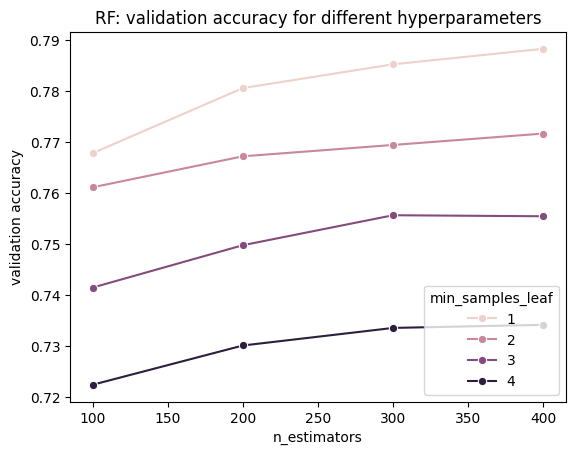

Best hyperparameters for RF:
 {'min_samples_leaf': 1, 'n_estimators': 400}



In [9]:
# RF grid search results
rf_results_df = pd.DataFrame(rf_grid_search.cv_results_)

sns.lineplot(
    data=rf_results_df,
    x='param_n_estimators',
    y='mean_test_score',
    marker='o',
    hue='param_min_samples_leaf',
    errorbar=None
)

plt.title('RF: validation accuracy for different hyperparameters')
plt.xlabel('n_estimators')
plt.ylabel('validation accuracy')
plt.legend(title='min_samples_leaf', loc='lower right')
plt.show()

# Best hyperparameters for RF
best_rf_hyperparams = rf_grid_search.best_params_
print(f'Best hyperparameters for RF:\n {best_rf_hyperparams}\n')

### RF: Model evaluation

RF validation accuracy: 0.848816029143898


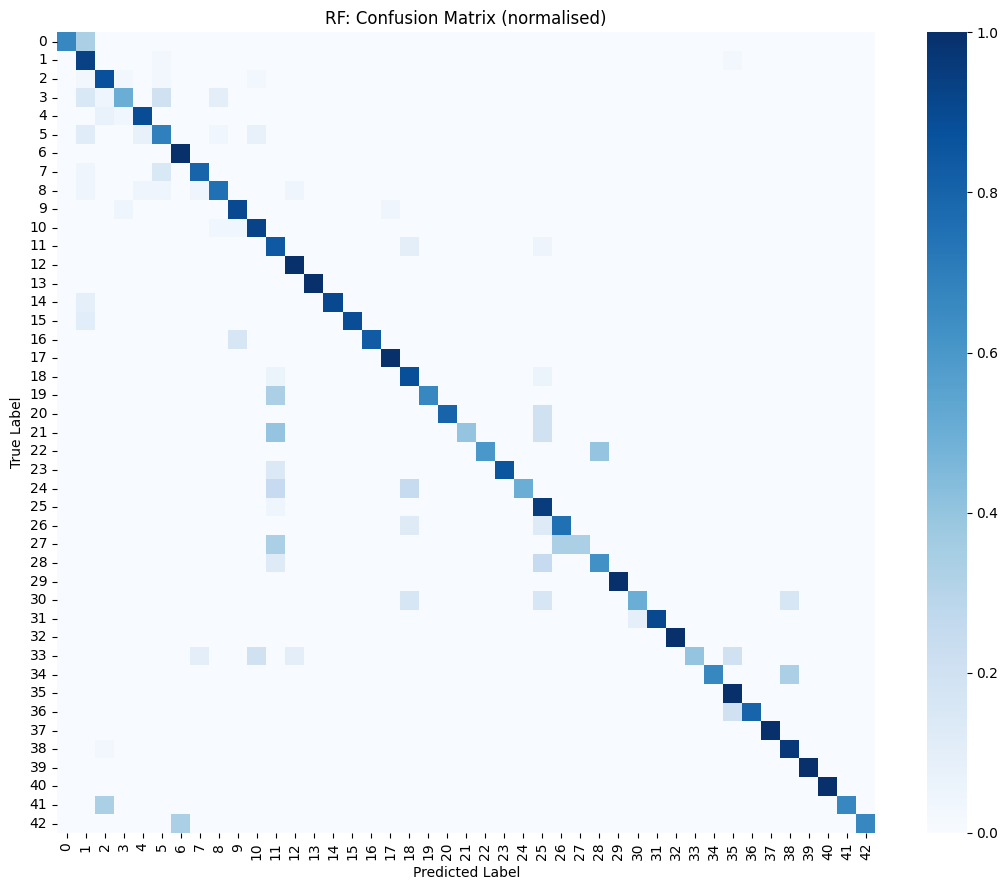

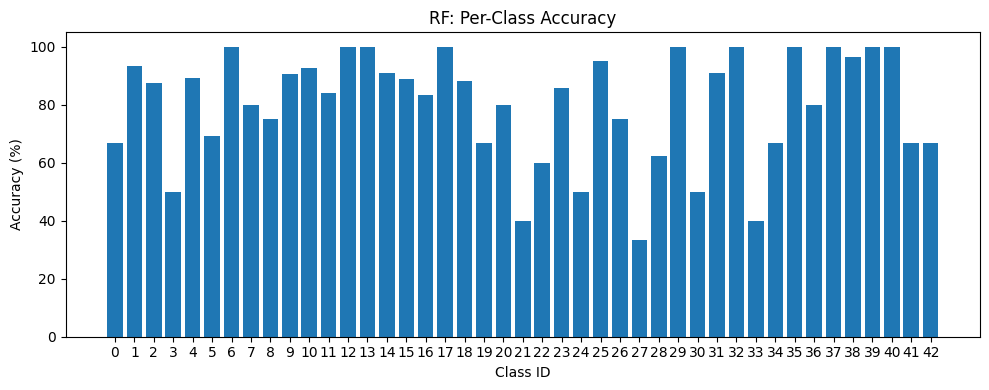

In [10]:
# Evaluate best RF model on validation set
best_rf_classifier = rf_grid_search.best_estimator_
y_val_rf_predicted = best_rf_classifier.predict(X_val_standardised)
print(f'RF validation accuracy: {accuracy_score(y_val, y_val_rf_predicted)}')

# Confusion matrix
rf_cm  = confusion_matrix(y_val, y_val_rf_predicted)
plt.figure(figsize=(11, 9))
sns.heatmap(rf_cm / rf_cm.sum(axis=1, keepdims=True), cmap='Blues', xticklabels=class_ids, yticklabels=class_ids)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('RF: Confusion Matrix (normalised)')
plt.tight_layout()
plt.show()

# Per-class accuracy
rf_per_class_accuracy = rf_cm.diagonal() / rf_cm.sum(axis=1)
plt.figure(figsize=(10, 4))
plt.bar(range(len(rf_per_class_accuracy)), rf_per_class_accuracy * 100)
plt.xlabel('Class ID')
plt.ylabel('Accuracy (%)')
plt.title('RF: Per-Class Accuracy')
plt.xticks(ticks=class_ids)
plt.tight_layout()
plt.show()

### RF: Final train + test

In [11]:
# Train final RF model on full labelled dataset [X, y]
optimal_n_estimators = rf_grid_search.best_params_['n_estimators']
optimal_min_samples_leaf = rf_grid_search.best_params_['min_samples_leaf']
final_rf_classifier = RandomForestClassifier(n_estimators=optimal_n_estimators, min_samples_leaf=optimal_min_samples_leaf, random_state=RANDOM_STATE)
final_rf_classifier.fit(X_standardised, y)

# Predict on unlabelled test set
y_test_rf_predicted = final_rf_classifier.predict(X_test_standardised)

# Write to csv for Kaggle submission
rf_submission = pd.DataFrame({
    'id': test_ids,
    'ClassId': y_test_rf_predicted
})
rf_submission.to_csv('rf_submission.csv', index=False)

## 3.2. Support Vector Machine (SVM)

### SVM: Define model and tune hyperparameters

In [12]:
# Define an SVM classifier
svm_classifier = SVC()

# Define hyperparameters for grid search
svm_param_grid = {
    'kernel': ['linear', 'poly', 'rbf'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

# Define GridSearchCV object
svm_grid_search = GridSearchCV(
    estimator = svm_classifier,
    param_grid=svm_param_grid,
    cv=3,
    scoring='accuracy',
    verbose=3,
    n_jobs=-1
)

# Run grid search on training data
svm_grid_search.fit(X_train_standardised, y_train)

Fitting 3 folds for each of 21 candidates, totalling 63 fits
[CV 2/3] END ............C=0.001, kernel=linear;, score=0.392 total time=   1.5s
[CV 3/3] END ............C=0.001, kernel=linear;, score=0.381 total time=   1.5s
[CV 1/3] END ............C=0.001, kernel=linear;, score=0.382 total time=   1.6s
[CV 1/3] END ..............C=0.001, kernel=poly;, score=0.057 total time=   1.7s
[CV 3/3] END ..............C=0.001, kernel=poly;, score=0.058 total time=   1.7s
[CV 2/3] END ..............C=0.001, kernel=poly;, score=0.057 total time=   1.8s
[CV 1/3] END ...............C=0.001, kernel=rbf;, score=0.057 total time=   2.3s
[CV 2/3] END ...............C=0.001, kernel=rbf;, score=0.057 total time=   2.4s
[CV 1/3] END .............C=0.01, kernel=linear;, score=0.677 total time=   1.1s
[CV 2/3] END .............C=0.01, kernel=linear;, score=0.688 total time=   1.1s
[CV 3/3] END .............C=0.01, kernel=linear;, score=0.668 total time=   1.0s
[CV 1/3] END ...............C=0.01, kernel=poly;

GridSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'kernel': ['linear', 'poly', 'rbf']},
             scoring='accuracy', verbose=3)

### SVM: Results from grid search

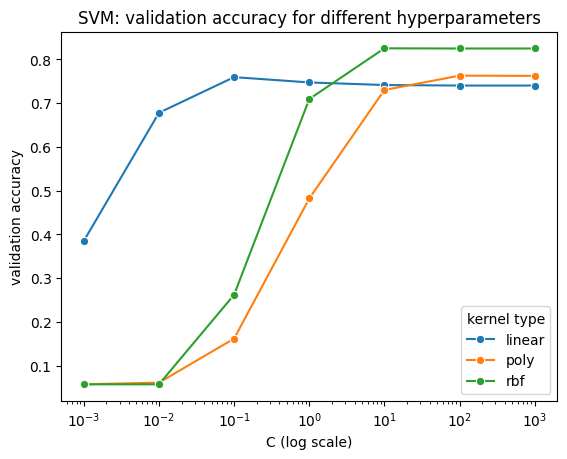

Best hyperparameters for SVM:
 {'C': 10, 'kernel': 'rbf'}



In [13]:
# SVM grid search results
svm_results_df = pd.DataFrame(svm_grid_search.cv_results_)

sns.lineplot(
    data=svm_results_df,
    x='param_C',
    y='mean_test_score',
    marker='o',
    hue='param_kernel',
    errorbar=None
)

plt.xscale('log')
plt.title('SVM: validation accuracy for different hyperparameters')
plt.xlabel('C (log scale)')
plt.ylabel('validation accuracy')
plt.legend(title='kernel type', loc='lower right')
plt.show()

# Best hyperparameters for SVM
best_svm_hyperparams = svm_grid_search.best_params_
print(f'Best hyperparameters for SVM:\n {best_svm_hyperparams}\n')

### SVM: Model evaluation

SVM validation accuracy: 0.8907103825136612


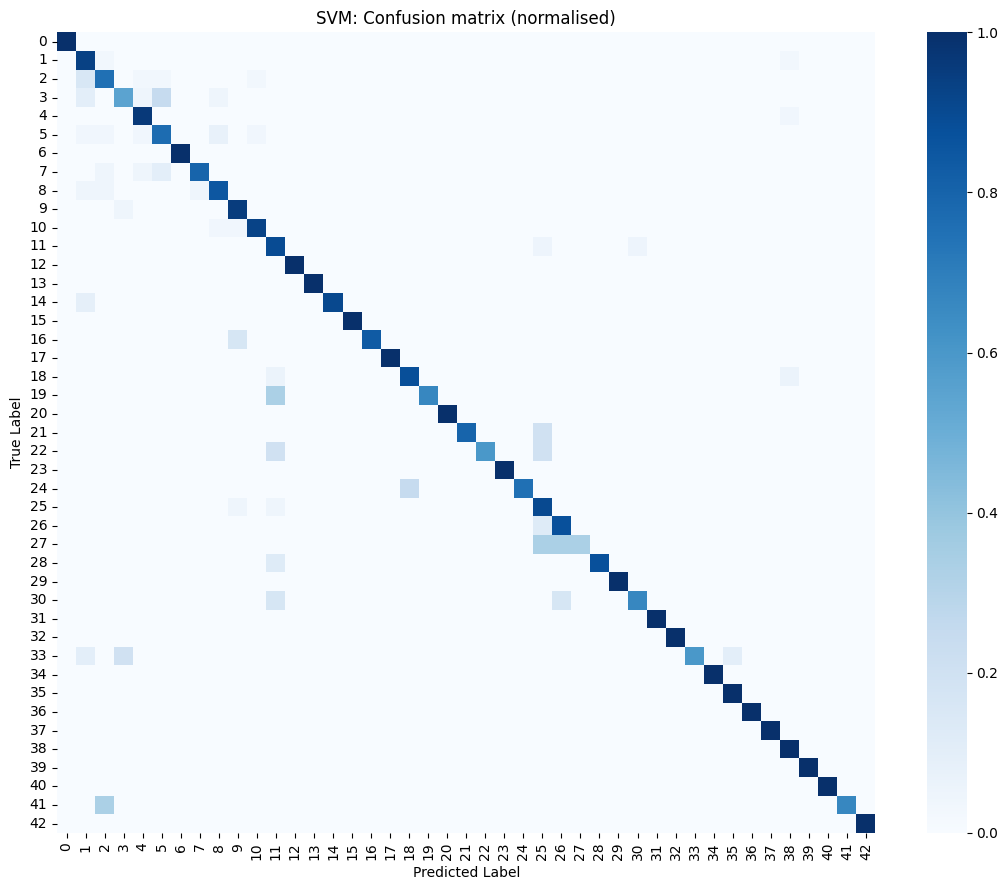

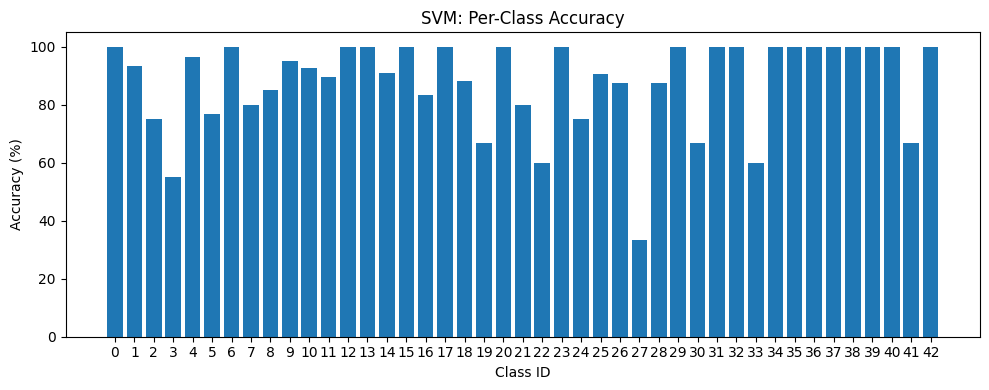

In [14]:
# Evaluate best SVM model on validation set
best_svm_classifier = svm_grid_search.best_estimator_
y_val_svm_predicted = best_svm_classifier.predict(X_val_standardised)
print(f'SVM validation accuracy: {accuracy_score(y_val, y_val_svm_predicted)}')

# Confusion matrix
svm_cm = confusion_matrix(y_val, y_val_svm_predicted)
plt.figure(figsize=(11, 9))
sns.heatmap(svm_cm / svm_cm.sum(axis=1, keepdims=True), cmap='Blues', xticklabels=class_ids, yticklabels=class_ids)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('SVM: Confusion matrix (normalised)')
plt.tight_layout()
plt.show()

# Per-class accuracy
svm_per_class_accuracy = svm_cm.diagonal() / svm_cm.sum(axis=1)
plt.figure(figsize=(10, 4))
plt.bar(range(len(svm_per_class_accuracy)), svm_per_class_accuracy * 100)
plt.xlabel('Class ID')
plt.ylabel('Accuracy (%)')
plt.title('SVM: Per-Class Accuracy')
plt.xticks(ticks=class_ids)
plt.tight_layout()
plt.show()

### SVM: Final train + test

In [15]:
# Train final SVM model on full labelled dataset [X_standardised, y]
optimal_kernel = svm_grid_search.best_params_['kernel']
optimal_C = svm_grid_search.best_params_['C']
final_svm_classifier = SVC(C=optimal_C, kernel=optimal_kernel)
final_svm_classifier.fit(X_standardised, y)

# Predict on unlabelled test set
y_test_svm_predicted = final_svm_classifier.predict(X_test_standardised)

# Write to csv for Kaggle submission
svm_submission = pd.DataFrame({
    'id': test_ids,
    'ClassId': y_test_svm_predicted
})
svm_submission.to_csv('svm_submission.csv', index=False)

## 3.3. Convolutional Neural Network (CNN)

Inspired by:
- https://www.tensorflow.org/tutorials/images/cnn
- https://www.datacamp.com/tutorial/complete-guide-data-augmentation
- https://pyimagesearch.com/2018/04/16/keras-and-convolutional-neural-networks-cnns/

### CNN: Define model

In [16]:
# CNN model
set_random_seed(RANDOM_STATE)

cnn_classifier = Sequential()

cnn_classifier.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_DIMS[0], IMG_DIMS[1], 3)))
cnn_classifier.add(BatchNormalization())
cnn_classifier.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
cnn_classifier.add(BatchNormalization())
cnn_classifier.add(MaxPooling2D(pool_size=(2, 2)))

cnn_classifier.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
cnn_classifier.add(BatchNormalization())
cnn_classifier.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
cnn_classifier.add(BatchNormalization())
cnn_classifier.add(MaxPooling2D(pool_size=(2, 2)))

cnn_classifier.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
cnn_classifier.add(BatchNormalization())
cnn_classifier.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
cnn_classifier.add(BatchNormalization())
cnn_classifier.add(MaxPooling2D(pool_size=(2, 2)))

cnn_classifier.add(Flatten())
cnn_classifier.add(Dense(512, activation='relu'))
cnn_classifier.add(Dropout(0.5))
cnn_classifier.add(Dense(num_classes, activation='softmax'))

# Compile CNN
cnn_classifier.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Create data augmentation object
data_generator = ImageDataGenerator(
    rotation_range=25,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    fill_mode='nearest'
)

# Train CNN
history = cnn_classifier.fit(
    x=data_generator.flow(X_cnn_train, y_cnn_train, batch_size=64, seed=RANDOM_STATE),
    validation_data=(X_cnn_val, y_cnn_val),
    epochs=30
)

/Users/zimdo/UniMelb/Y3S1/COMP30027 (ML)/A02/ml-a02-venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-05-23 18:06:32.686497: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-05-23 18:06:32.686693: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-05-23 18:06:32.686704: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
I0000 00:00:1747987592.687121 4741464 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1747987592.687515 4741464 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localho

Epoch 1/30


/Users/zimdo/UniMelb/Y3S1/COMP30027 (ML)/A02/ml-a02-venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-05-23 18:06:34.031258: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


78/78 ━━━━━━━━━━━━━━━━━━━━ 10s 83ms/step - accuracy: 0.0803 - loss: 15.7882 - val_accuracy: 0.0565 - val_loss: 6.4485
Epoch 2/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - accuracy: 0.1774 - loss: 14.8989 - val_accuracy: 0.0674 - val_loss: 11.6403
Epoch 3/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - accuracy: 0.2672 - loss: 13.9528 - val_accuracy: 0.2623 - val_loss: 6.9242
Epoch 4/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.3619 - loss: 12.3140 - val_accuracy: 0.3151 - val_loss: 7.8709
Epoch 5/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - accuracy: 0.4266 - loss: 10.8000 - val_accuracy: 0.6011 - val_loss: 3.1863
Epoch 6/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - accuracy: 0.5053 - loss: 8.7354 - val_accuracy: 0.6503 - val_loss: 3.5468
Epoch 7/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - accuracy: 0.5685 - loss: 7.2744 - val_accuracy: 0.7978 - val_loss: 1.5121
Epoch 8/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - accuracy: 0.6075 - loss: 6.4989 - val_accuracy: 0.8525 - val_l

### CNN: Model evaluation

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9873 - loss: 0.1309 
CNN validation accuracy: 0.9799635410308838
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


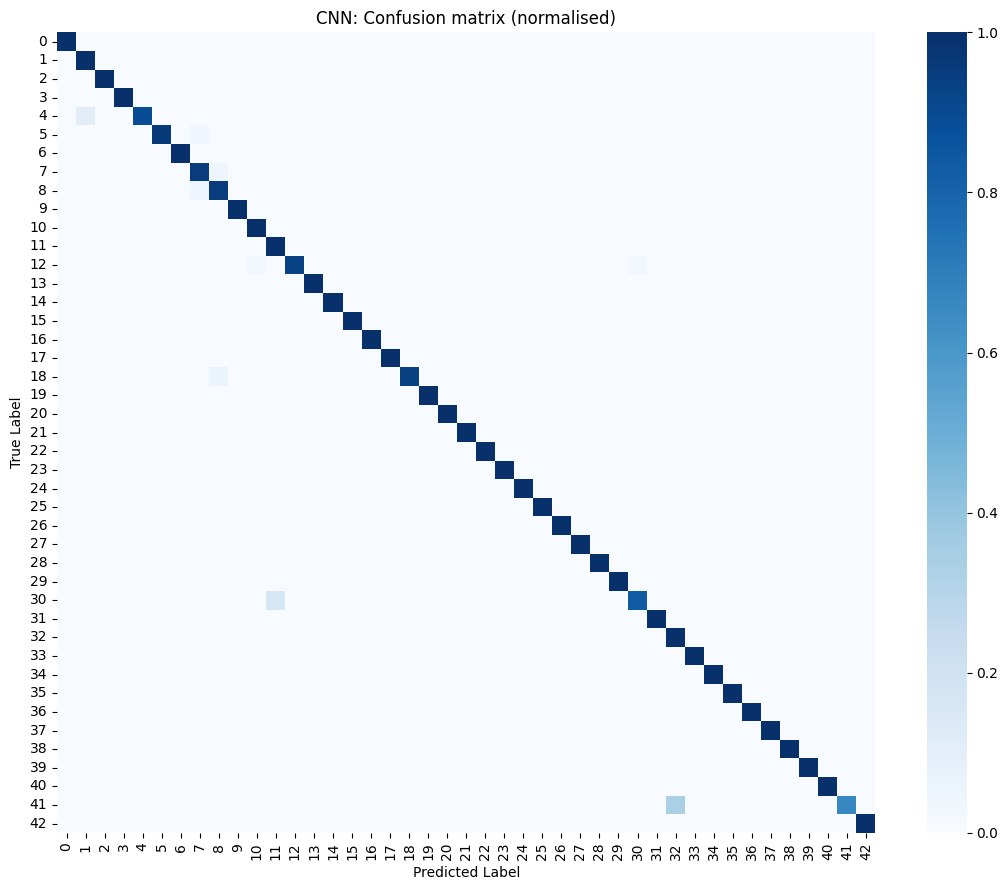

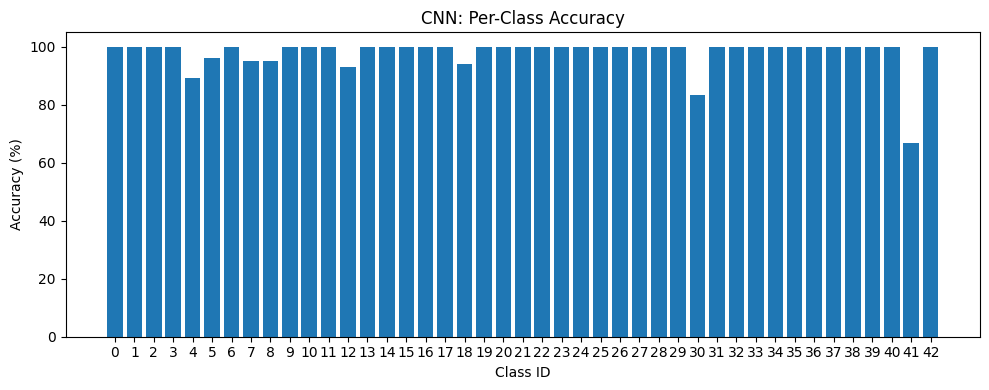

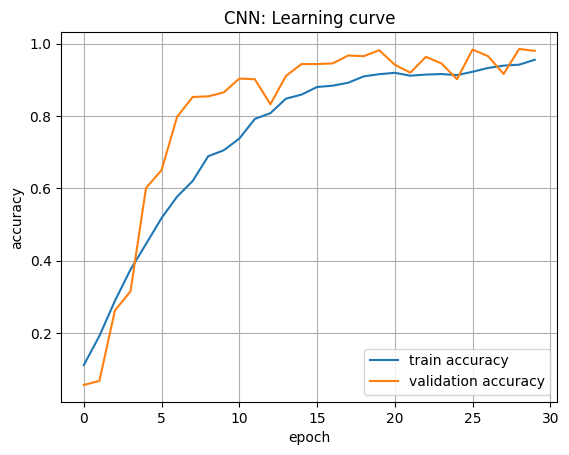

In [17]:
# Evaluate CNN performance on validation set
val_loss, val_accuracy = cnn_classifier.evaluate(X_cnn_val, y_cnn_val)
print(f'CNN validation accuracy: {val_accuracy}')

# Confusion matrix
y_val_cnn_probs = cnn_classifier.predict(X_cnn_val)
y_val_cnn_predicted = np.argmax(y_val_cnn_probs, axis=1)
cnn_cm = confusion_matrix(y_val, y_val_cnn_predicted)
plt.figure(figsize=(11, 9))
sns.heatmap(cnn_cm / cnn_cm.sum(axis=1, keepdims=True), cmap='Blues', xticklabels=class_ids, yticklabels=class_ids)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('CNN: Confusion matrix (normalised)')
plt.tight_layout()
plt.show()

# Per-class accuracy
cnn_per_class_accuracy = cnn_cm.diagonal() / cnn_cm.sum(axis=1)
plt.figure(figsize=(10, 4))
plt.bar(range(len(cnn_per_class_accuracy)), cnn_per_class_accuracy * 100)
plt.xlabel('Class ID')
plt.ylabel('Accuracy (%)')
plt.title('CNN: Per-Class Accuracy')
plt.xticks(ticks=class_ids)
plt.tight_layout()
plt.show()

# Plot learning curve
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('CNN: Learning curve')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

### CNN: Final train + test

In [18]:
# Retrain on full dataset
cnn_classifier.fit(
    data_generator.flow(X_cnn, y_cnn, batch_size=64),
    epochs=30,
)

# Predict on unlabelled test set
y_test_cnn_prob = cnn_classifier.predict(X_cnn_test)
y_test_cnn_predicted = np.argmax(y_test_cnn_prob, axis=1)

# Write to csv for Kaggle submission
cnn_submission = pd.DataFrame({
    'id': test_ids,
    'ClassId': y_test_cnn_predicted
})
cnn_submission.to_csv('cnn_submission.csv', index=False)

Epoch 1/30
 1/86 ━━━━━━━━━━━━━━━━━━━━ 8s 105ms/step - accuracy: 0.9531 - loss: 0.9841

/Users/zimdo/UniMelb/Y3S1/COMP30027 (ML)/A02/ml-a02-venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


86/86 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step - accuracy: 0.9496 - loss: 0.6967
Epoch 2/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - accuracy: 0.9513 - loss: 0.5809
Epoch 3/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - accuracy: 0.9498 - loss: 0.6373
Epoch 4/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - accuracy: 0.9584 - loss: 0.5364
Epoch 5/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - accuracy: 0.9514 - loss: 0.7342
Epoch 6/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.9600 - loss: 0.5361
Epoch 7/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step - accuracy: 0.9641 - loss: 0.5091
Epoch 8/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - accuracy: 0.9621 - loss: 0.4586
Epoch 9/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.9664 - loss: 0.4095
Epoch 10/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.9671 - loss: 0.4857
Epoch 11/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step - accuracy: 0.9655 - loss: 0.4262
Epoch 12/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.9683 - l

# EXTRA: Show different traffic sign classes

/var/folders/g7/nymy8gfj7dz2v9kc3z9mygwm0000gn/T/ipykernel_80870/1413650492.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  samples = train_df.groupby('ClassId').apply(lambda x: x.sample(1, random_state=RANDOM_STATE)).reset_index(drop=True)


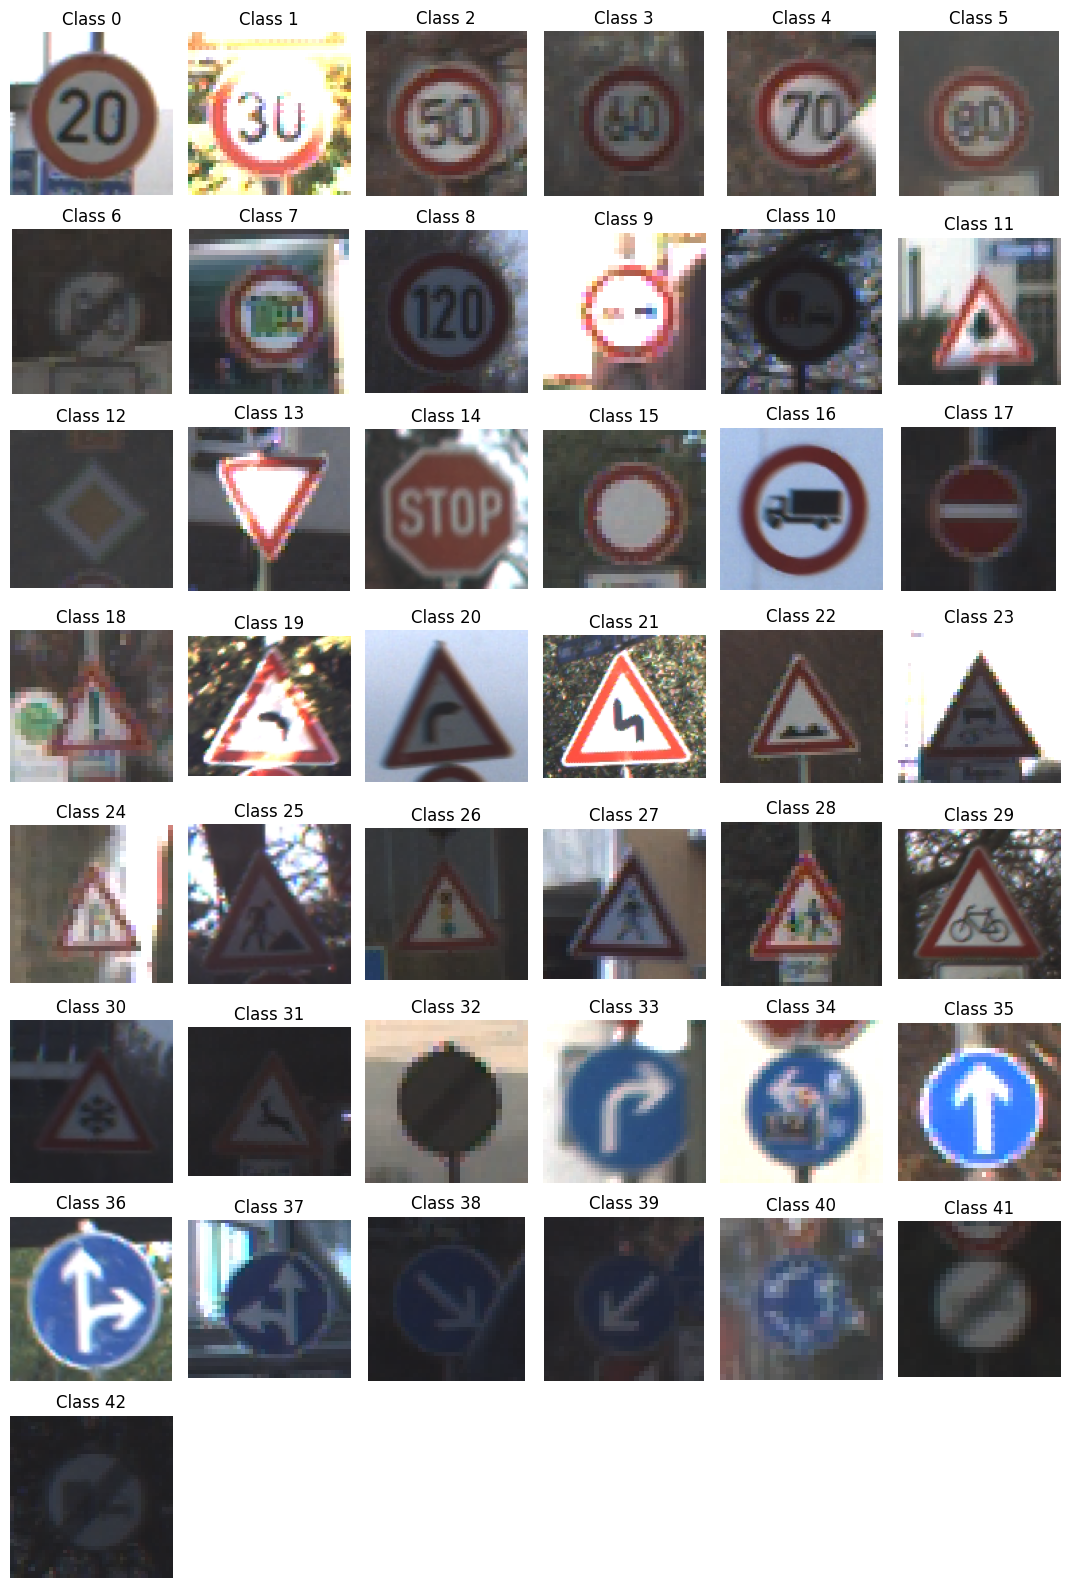

In [19]:
# Pick one random image per class
samples = train_df.groupby('ClassId').apply(lambda x: x.sample(1, random_state=RANDOM_STATE)).reset_index(drop=True)

# Plot settings
cols = 6
rows = (num_classes // cols) + 1
plt.figure(figsize=(cols * 1.8, rows * 2))

# Plot an image from each class
for i, row in samples.iterrows():
    img_path = f'./data/train/{row["image_path"]}'
    img = cv2.imread(img_path)
    
    # Convert to RGB and brighten
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_bright = cv2.convertScaleAbs(img_rgb, alpha=1, beta=20)

    plt.subplot(rows, cols, i + 1)
    plt.imshow(img_bright)
    plt.title(f'Class {row["ClassId"]}')
    plt.axis('off')

plt.tight_layout()
plt.show()